In [1]:
import numpy as np
import matplotlib.pyplot as plt
from hlxon_hdf5io import *
from scipy.spatial.transform import Rotation
from filters.HelixonKalmanFilter import *
from metrics import *

In [2]:
def quaternion_multiply(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 - x1 * z2 + y1 * w2 + z1 * x2
    z = w1 * z2 + x1 * y2 - y1 * x2 + z1 * w2
    return np.array([w, x, y, z])

In [3]:
def angular_distance(b, a):
    return np.where(np.abs(b-a) < 180, b-a, np.where((b-a) > 0, 360 - (b-a), 360 + (b-a)))

# Load data


In [4]:
# get data from hdf5
raw_timestamp, raw_9dof, raw_rpy, raw_bno, raw_bmp, raw_pressure, wifidata, gt_timestamp, gt_position, gt_orientation = readHDF5('RandomUDP3')

# p0 is first real pressure measurement
p0 = max(raw_pressure)

# convenience
X, Y, Z = 0, 1, 2
N = len(raw_timestamp)

# get sensor data
araw = np.array(raw_9dof[:, :3])
gyro = np.array(raw_9dof[:, 3:6])
magn = np.array(raw_9dof[:, 6:])
pres = np.array(raw_pressure).reshape((-1, 1))
alpha = 1.16e-4
ts = np.array(raw_timestamp)*1e-6
gt_timestamp = np.array(gt_timestamp)*1e-6


# Preprocess Data

In [5]:

rots = np.array([Rotation.from_quat(q).as_euler('xyz', degrees=True) for q in gt_orientation]) # change quat gt rots to euler
rots -= rots[0] # normalize to initial rot
rots = rots[:, ::-1] # reverse order of xyz to match ndof
rots[:, X] *= -1 # invert X rotations to match ndof
rots = np.array([Rotation.from_euler('xyz', r, degrees=True).as_euler('xyz', degrees=True) for r in rots])

# lerp rots
N = len(rots)

# interpolate over timestamps
lerped_rotations = np.zeros((N, 3))
for i in range(N):
    if gt_timestamp[i] in ts:
        lerped_rotations[i] = raw_rpy[np.argmax(ts == gt_timestamp[i])]
    else:
        # lerp
        ix_2 = np.argmax(ts > gt_timestamp[i])
        ix_1 = ts.shape[0] - np.argmax(np.flip(ts, axis=0) < gt_timestamp[i]) - 1

        lerped_rotations[i] = raw_rpy[ix_1] + (gt_timestamp[i]-ts[ix_1])*angular_distance(raw_rpy[ix_2], raw_rpy[ix_1])/(ts[ix_2] - ts[ix_1] + 1e-10)

rpy = lerped_rotations

# Extract Window with Largest Error

[-56.36366723   6.99879381   2.37248733] [174.31521144   5.50065732   4.24975351] [129.32112134  -1.49813649   1.87726618]


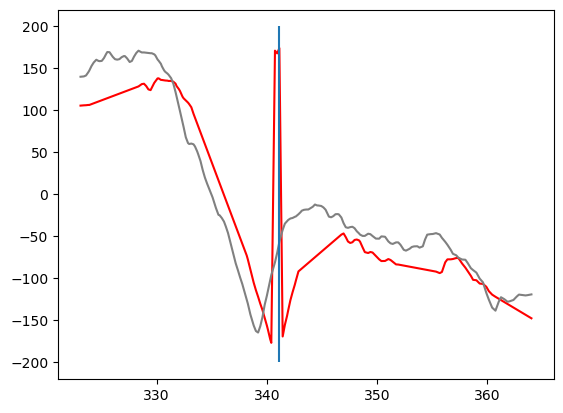

In [6]:
ixmax = np.argmax(np.linalg.norm(angular_distance(rpy, rots), axis=1))
print(rots[ixmax], rpy[ixmax], angular_distance(rpy[ixmax], rots[ixmax]))
windowsize = 200
window = (max(0, ixmax-windowsize//2), min(len(rpy)-1, ixmax+windowsize//2))

# plot positions as functions of time
fig = plt.figure()
ax = plt.axes()
ax.plot(gt_timestamp[window[0]:window[1]], rpy[window[0]:window[1], X], color='red')
ax.plot(gt_timestamp[window[0]:window[1]], rots[window[0]:window[1], X], color='gray')
ax.vlines(gt_timestamp[ixmax], -200, 200)
plt.show()


# Evaluate Performance

In [7]:
# Evaluate
print('-------------Shortest Angle Errors (norm of XYZ error)-------------')
# median angle error
ade = np.median(np.linalg.norm(np.abs(angular_distance(rpy, rots)), axis=1))
print(f'angle median angle error: {ade}')

# average angle error
ade = np.mean(np.linalg.norm(np.abs(angular_distance(rpy, rots)), axis=1))
print(f'angle average angle error: {ade}')

# max angle error
mde = np.linalg.norm(np.abs(angular_distance(rpy, rots)), axis=1).max()
print(f'angle max angle error: {mde}')

# root mean squared error over angles
msde = np.sqrt(np.mean(np.linalg.norm(np.abs(angular_distance(rpy, rots)), axis=1)**2))
print(f'angle root mean squared angle error: {msde}')

print('-------------Individual Angle Component Errors-------------')
# median angle error
ade = np.median(np.abs(angular_distance(rpy, rots)), axis=0)
print(f'angle median angle error: {ade}')

# average angle error
ade = np.mean(np.abs(angular_distance(rpy, rots)), axis=0)
print(f'angle average angle error: {ade}')

# max angle error
mde = (np.abs(angular_distance(rpy, rots))).max(axis=0)
print(f'angle max angle error: {mde}')

# root mean squared error over angles
msde = np.sqrt(np.mean((np.abs(angular_distance(rpy, rots)))**2, axis=0))
print(f'angle root mean squared angle error: {msde}')


-------------Shortest Angle Errors (norm of XYZ error)-------------
angle median angle error: 22.533187587221693
angle average angle error: 26.294273679577405
angle max angle error: 129.3434225821321
angle root mean squared angle error: 32.52028554609628
-------------Individual Angle Component Errors-------------
angle median angle error: [22.27678764  1.74038961  1.74179457]
angle average angle error: [25.78633842  2.13790803  2.11812523]
angle max angle error: [129.32112134  10.9525165   11.81130058]
angle root mean squared angle error: [32.29124233  2.73519206  2.7135521 ]


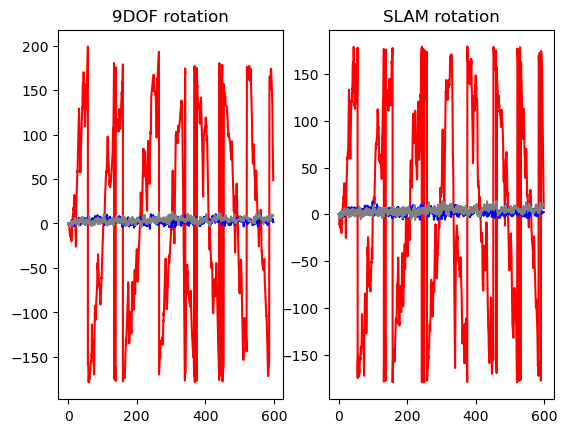

In [8]:

# plot positions as functions of time
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('9DOF rotation')
ax1.plot(gt_timestamp, rpy[:, X], color='red')
ax1.plot(gt_timestamp, rpy[:, Y], color='blue')
ax1.plot(gt_timestamp, rpy[:, Z], color='gray')

ax2.set_title('SLAM rotation')
ax2.plot(gt_timestamp, rots[:, X], color='red')
ax2.plot(gt_timestamp, rots[:, Y], color='blue')
ax2.plot(gt_timestamp, rots[:, Z], color='gray')
plt.show()